# Clustering K-means  
Dataset Used: California Housing Prices

Business Objective : To identify and categorize buildings as either "New" or "Old" based on housing median age and geographic location.

# Using SciKit

K-Means Clustering Algorithm is used to group the houses into K clusters based on the similarity of their features.
In this case, houses are grouped by age (housing_median_age) and geographic location (longitude and latitude).

In [1]:
## Standard Imports
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import seaborn as sns

In [2]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# id of the dataset csv file in the google drive shared folder

id='1vaDWspyv3WZrcvdvDyNLSYVuErX3m9Zc'
print (id)

1vaDWspyv3WZrcvdvDyNLSYVuErX3m9Zc


In [4]:
## Loading Dataset

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('housing.csv')
data = pd.read_csv('housing.csv')
data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [7]:
# Data Wrangling and Preparation

# to Drop rows with missing values and extract the feature required for clustering
data.dropna(inplace=True)
features = data[['housing_median_age', 'longitude', 'latitude']].values

#Added for Tensorflow
dPts = features

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

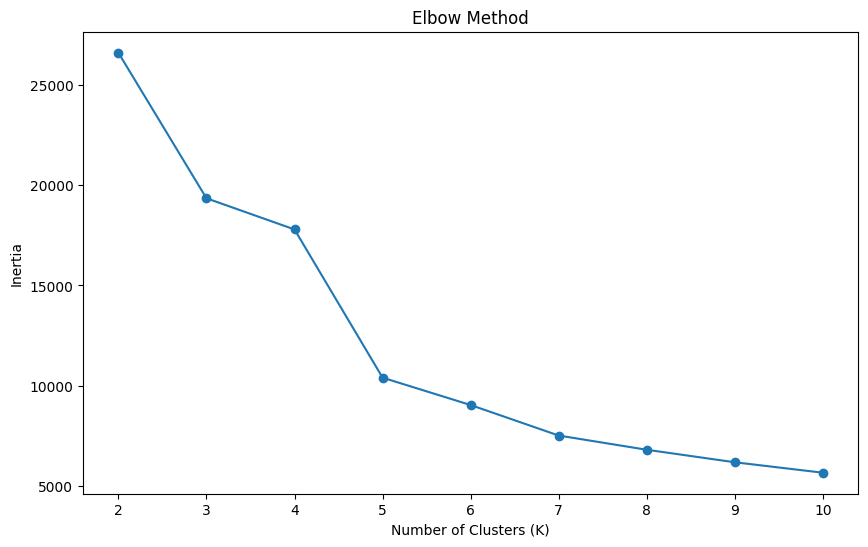

In [8]:
# Find Optimal K value using elbow method and silhouette method

inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


**Based on the above elbow method we can determine that optimal k-value is 5**

In [9]:
# Apply k-means clustering algorithm

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

data['cluster'] = clusters

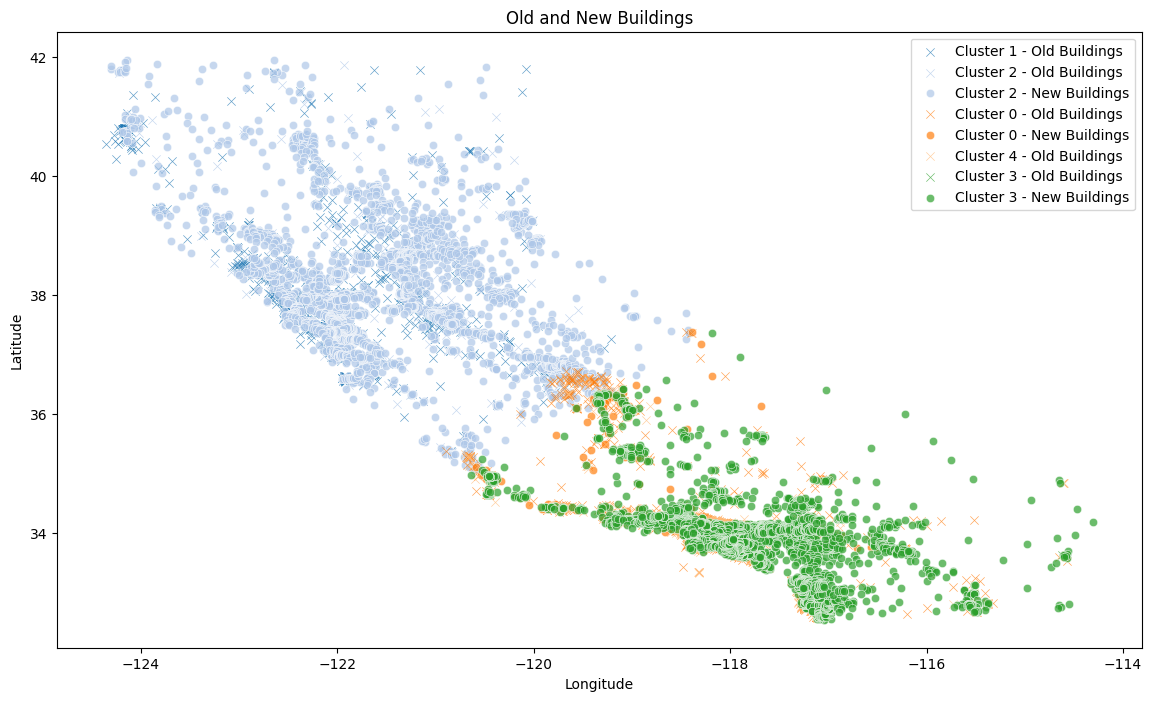

In [10]:
# Determine age threshold to differentiate older and newer buildings in each cluster

age_threshold = data['housing_median_age'].quantile(0.4)

colors = sns.color_palette('tab20', n_colors=len(data['cluster'].unique()))

plt.figure(figsize=(14, 8))

for cluster_id, color in zip(data['cluster'].unique(), colors):
    cluster_data = data[data['cluster'] == cluster_id]

    # Categorize buildings into older and newer buildings by comparing the housing_median_age with age_threshold

    older_buildings = cluster_data[cluster_data['housing_median_age'] > age_threshold]
    newer_buildings = cluster_data[cluster_data['housing_median_age'] <= age_threshold]

    sns.scatterplot(data=older_buildings, x='longitude', y='latitude',
                    color=color, marker='x', label=f'Cluster {cluster_id} - Old Buildings', alpha=0.7)
    sns.scatterplot(data=newer_buildings, x='longitude', y='latitude',
                    color=color, marker='o', label=f'Cluster {cluster_id} - New Buildings', alpha=0.7)

plt.title('Old and New Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Using Tensor Flow

In [11]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Standardize the 'housing_median_age' feature for clustering.

mms = MinMaxScaler()
dPts[:, 0] = mms.fit_transform(dPts[:, 0].reshape(-1, 1)).flatten()

In [12]:
def input_fn():
    return tf.compat.v1.train.limit_epochs(
        tf.convert_to_tensor(dPts, dtype=tf.float32), num_epochs=1)

In [13]:
# K-means is in TensorFlow 2.0 compatible mode
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

num_clusters = 5

kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)

# Train the K-means model
num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
    kmeans.train(input_fn)
    cluster_centers = kmeans.cluster_centers()
    if previous_centers is not None:
        print('delta:', cluster_centers - previous_centers)
    previous_centers = cluster_centers
    print('score:', kmeans.score(input_fn))
print('cluster centers:', cluster_centers)

score: 257558.92
delta: [[-0.01134199 -2.3958054   2.6660843 ]
 [ 0.06411532  0.08715057 -0.0713501 ]
 [-0.06809154  0.35674286 -0.4163208 ]
 [-0.10500306 -0.6691818   1.5343094 ]
 [-0.02681839  0.01165009  0.09641647]]
score: 42958.66
delta: [[-0.02937847 -1.0329514   1.2533379 ]
 [-0.07377002  0.01605225 -0.00378036]
 [-0.00705838  0.18492126 -0.2612419 ]
 [ 0.1975162  -0.502655   -0.15426254]
 [-0.0368889  -0.20015717  0.12258148]]
score: 15803.999
delta: [[ 0.0086996  -0.17832947  0.15866852]
 [ 0.01154593  0.1438675  -0.05905533]
 [ 0.01859376  0.07849121 -0.13110733]
 [ 0.00240815 -0.3404541   0.41208267]
 [-0.03743106 -0.04062653  0.03682709]]
score: 14464.556
delta: [[ 0.00129092 -0.01624298  0.01160812]
 [ 0.0005157   0.06808472 -0.01392746]
 [ 0.00733632  0.01669312 -0.05615616]
 [-0.0081245  -0.07583618  0.18031311]
 [-0.0236342  -0.02052307  0.01741791]]
score: 14306.19
delta: [[ 0.00072098 -0.00698853  0.00476837]
 [-0.0010497   0.02330017 -0.00990677]
 [ 0.00210834  0.001

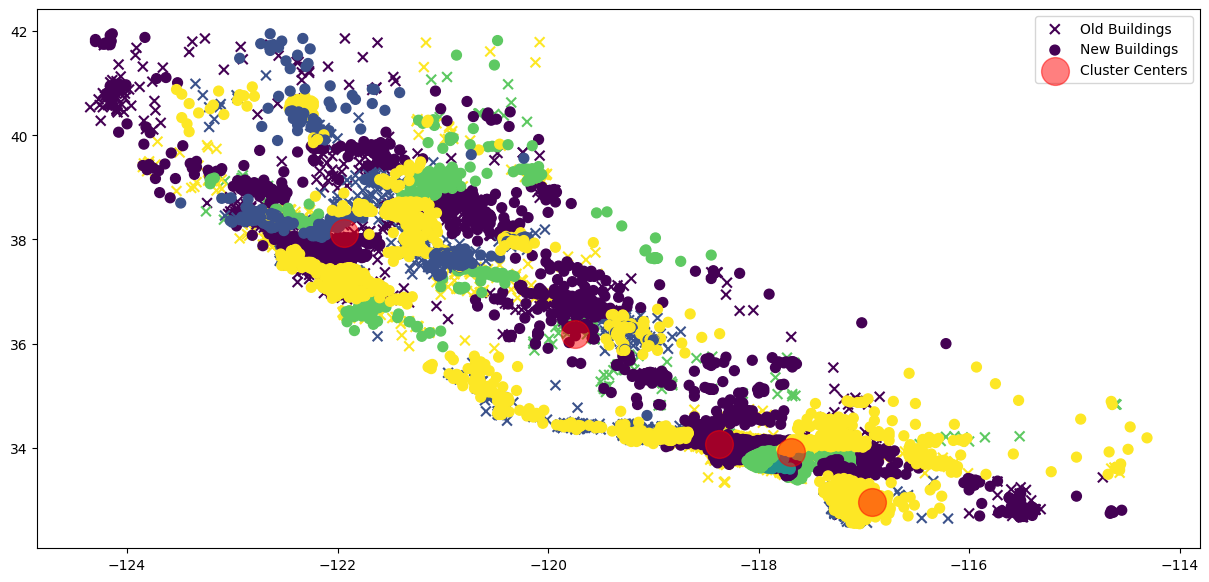

In [14]:
# Map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))

centers = kmeans.cluster_centers()

# Categorize buildings into older and newer buildings by comparing the housing_median_age with age_threshold
threshold = 0.4
buildings_old = dPts[dPts[:, 0] >= threshold]
buildings_new = dPts[dPts[:, 0] < threshold]

# Plot old and new buildings in different clusters
plt.subplots(figsize=(15, 7))

# Plot old buildings with 'x' marker
plt.scatter(buildings_old[:, 1], buildings_old[:, 2], c=cluster_indices[:len(buildings_old)], s=50, cmap='viridis', marker='x', label='Old Buildings')

# Plot new buildings with 'o' marker
plt.scatter(buildings_new[:, 1], buildings_new[:, 2], c=cluster_indices[:len(buildings_new)], s=50, cmap='viridis', marker='o', label='New Buildings')

# Plot cluster centers
plt.scatter(centers[:, 1], centers[:, 2], c='red', s=400, alpha=0.5, label='Cluster Centers')

plt.legend()
plt.show()

# Conclusion

Old and New buildings are differentiated within each cluster
by checking housing_median_age with age threshold (age_threshold).

Marker x - indicates the number of old buildings distributed geographically within each cluster.

Marker o - indicates the number of new buildings distributed geographically within each cluster.

We can interpret from the above graphs that Cluster 1 and 4 consist of old buildings, Cluster 2, 3, and 5 consist of old and new buildings.

Categorizing buildings into New or Old would enable real estate professionals to make informed decisions regarding renovation, redevelopment or investment strategies.

# Using DBSCAN Clustering Algorithm

In [15]:
# Apply DBSCAN clustering algorithm

eps = 0.5
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
noofclusters = dbscan.fit_predict(features_scaled)
data['cluster'] = noofclusters

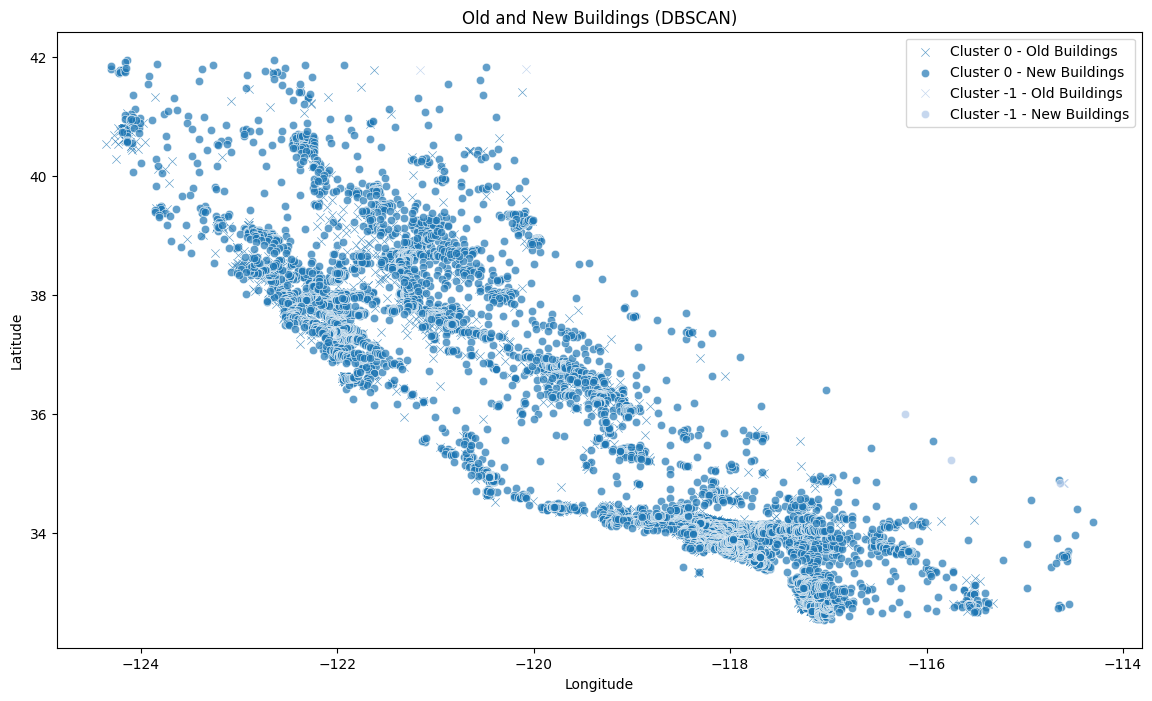

In [16]:
# Determine age threshold to differentiate older and newer buildings in each cluster

age_threshold = data['housing_median_age'].quantile(0.5)

colors = sns.color_palette('tab20', n_colors=len(data['cluster'].unique()))

plt.figure(figsize=(14, 8))

for cluster_id, color in zip(data['cluster'].unique(), colors):
    cluster_data = data[data['cluster'] == cluster_id]

    # Categorize buildings into older and newer buildings by comparing the housing_median_age with age_threshold

    older_buildings = cluster_data[cluster_data['housing_median_age'] > age_threshold]
    newer_buildings = cluster_data[cluster_data['housing_median_age'] <= age_threshold]

    sns.scatterplot(data=older_buildings, x='longitude', y='latitude',
                    color=color, marker='x', label=f'Cluster {cluster_id} - Old Buildings', alpha=0.7)
    sns.scatterplot(data=newer_buildings, x='longitude', y='latitude',
                    color=color, marker='o', label=f'Cluster {cluster_id} - New Buildings', alpha=0.7)

plt.title('Old and New Buildings (DBSCAN)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

The key difference between K-means and DBSCAN is that DBSCAN doesn't require specifying the number of clusters in advance and can discover clusters of arbitrary shapes. It identifies clusters based on data density, making it suitable. By adjusting the eps and min_samples parameters we can control the granularity and number of clusters DBSCAN identifies in the given dataset.

# References

Dataset : https://www.kaggle.com/datasets/camnugent/california-housing-prices

Load CSV file into google colab : https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92#:~:text=Click%20on%20the%20dataset%20in,read_csv%20to%20get%20the%20dataframe

Scalar Information : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Clustering Methods : https://scikit-learn.org/stable/modules/clustering#overview-of-clustering-methods

Finding Optimal K value :

*   https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

*   https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

TensorFlow : https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/compat/v1/estimator/experimental/KMeans?hl=en#example



